In [12]:
import json
import math
from functools import partial
from pathlib import Path
from configparser import ConfigParser

import umap
import hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.graph_objs import Scatter, Layout, Heatmap
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import chart_studio
import chart_studio.plotly as py

from src.aggregator import *

pd.set_option('display.max_colwidth', -1)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_19836\3496233029.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Data

In [13]:
df=pd.read_csv('data/interim/stenos_cleaned_topics.csv')
df.shape

(209949, 22)

In [14]:
#normalize factions
df['fation']=df.fation.replace({'Fraktsiooni mittekuuluvad saadikud': 'Fraktsioonidesse mittekuulunud Riigikogu liikmed',
                               'Fraktsiooni mittekuuluvad Riigikogu liikmed':'Fraktsioonidesse mittekuulunud Riigikogu liikmed'})

In [15]:
df_topic_clusters=pd.read_excel('data/interim/riigikogu_topics_clusters.xlsx')
df_topic_clusters['topic_words3']=df_topic_clusters.words.apply(lambda x: ' '.join(x.split()[:3]))
df_topic_clusters.shape

(1152, 9)

## Colors for plotting

In [16]:
colors=json.loads(Path('utils/colors.json').read_text())
colors=list(colors.keys())[10:]

## Add topics to original data

In [17]:
df=pd.merge(df, df_topic_clusters[['topic_cluster_id','topic_id', 'x_rand', 'y_rand']], 
            left_on='topic_id', right_on='topic_id', how='left')
df.shape

(209949, 25)

## Clusters which are noninformative

In [18]:
clusters_noninform=pd.read_csv('data/interim/noninform_clusters.csv')['0'].tolist()
topics_noninform=pd.read_csv('data/interim/noninform_topics.csv')['0'].tolist()

## Topics related to environment

In [19]:
topics_environment=[['energiaagentuur', 'agentuuri', 'agentuur'],
                   ['korterelamute', 'kortermajade', 'kredexi'],
                   ['metsa', 'metsade', 'mets'],
                   ['elektri', 'elektrit', 'taastuvenergia'],
                   ['utah', 'jordaania', 'energia'],
                   ['loomi', 'loomade', 'loomad'],
                   ['muundatud', 'geneetiliselt', 'gmo'],
                   ['hoone', 'rkas', 'hoonet'],
                   ['oiglase', 'virumaale', 'ulemineku'],
                   ['kala', 'kalurid', 'kalurite'],
                   ['jaatmeid', 'liigiti', 'prugi'],
                   ['planeeringu', 'keskkonnamoju', 'keskkonnamojude'],
                   ['kala', 'kalurid', 'kalurite'],
                   ['lng', 'terminali', 'gaasi'],
                   ['est', 'kavatsuste', 'for']]

topics_env_str=[' '.join(lst) for lst in topics_environment]

In [20]:
df['topic_env']=np.where(df.topic_words3.isin(topics_env_str), df.topic_words3, 'other')

In [66]:
df['topic_env'].value_counts()

other                                        204479
elektri elektrit taastuvenergia              1748  
metsa metsade mets                           757   
hoone rkas hoonet                            492   
loomi loomade loomad                         385   
korterelamute kortermajade kredexi           357   
lng terminali gaasi                          346   
jaatmeid liigiti prugi                       333   
kala kalurid kalurite                        245   
oiglase virumaale ulemineku                  228   
planeeringu keskkonnamoju keskkonnamojude    172   
utah jordaania energia                       167   
energiaagentuur agentuuri agentuur           119   
muundatud geneetiliselt gmo                  80    
est kavatsuste for                           41    
Name: topic_env, dtype: int64

## Environment topics semantic space

C:\Users\RistoHinno\anaconda3\lib\site-packages\seaborn\relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


<AxesSubplot:xlabel='x_rand', ylabel='y_rand'>

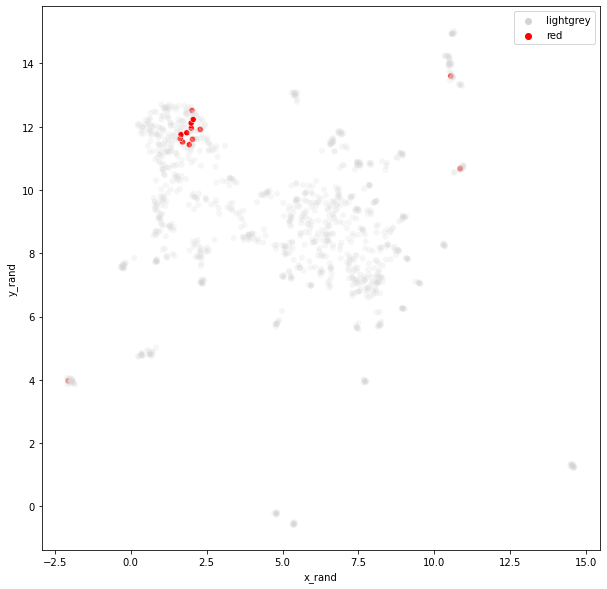

In [41]:
color_env_cluster=np.where(df_topic_clusters.topic_words3.isin(topics_env_str), 'red', 'lightgrey')
alpha=np.where(df_topic_clusters.topic_words3.isin(topics_env_str), 1, 0.2)
figsize=(10,10)
# alpha=0.5
fig, ax =plt.subplots(figsize=figsize)
sns.scatterplot(x=df_topic_clusters['x_rand'],
                y=df_topic_clusters['y_rand'], 
                ax=ax, 
                #size=50,
                hue=color_env_cluster, 
                palette=set(color_env_cluster),
                alpha=alpha)

In [57]:
def plot_scatter(df, figsize=(10,10), alpha=0.5, s=100):
    fig, ax =plt.subplots(figsize=figsize)
    sns.scatterplot(x=df['x_rand'],
                    y=df['y_rand'], 
                    ax=ax, 
                    s=s,
                    hue=df.color_topic_cluster, 
                    alpha=alpha)

    for i, point in df.iterrows():
        ax.text(point['x_rand']+.02, point['y_rand'], str(point['topic_words3']))

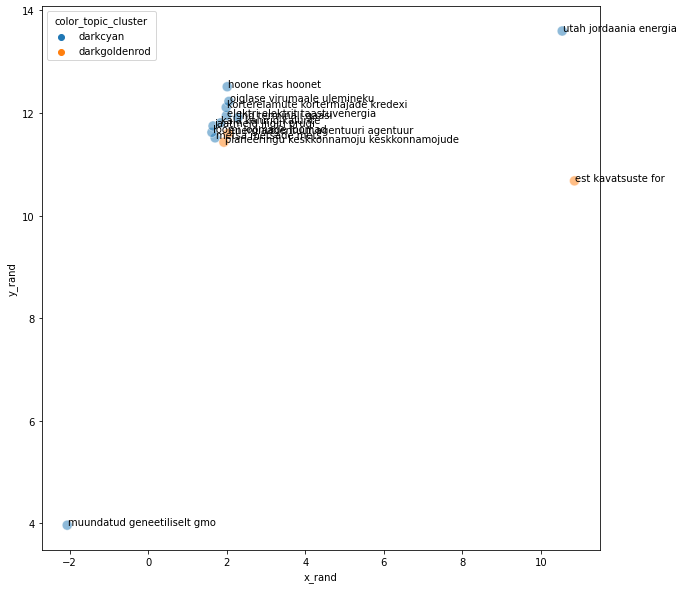

In [59]:
df_env_topic_clusters=df_topic_clusters[df_topic_clusters.topic_words3.isin(topics_env_str)]
plot_scatter(df_env_topic_clusters)

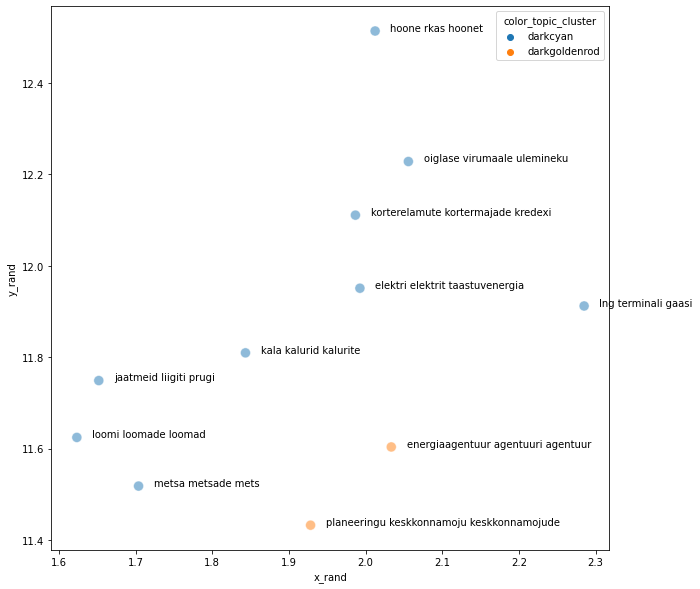

In [60]:
#without outliers
df_env_topic_clusters_sub=df_env_topic_clusters[(df_env_topic_clusters.x_rand<9)&(df_env_topic_clusters.x_rand>0)]
plot_scatter(df_env_topic_clusters_sub)

## See factions how much each topic is in their turns

In [62]:
df.columns

Index(['heading', 'speaker', 'link_video', 'link_steno', 'index_pk',
       'index_snd', 'text', 'year', 'month', 'day', 'time',
       'seconds_from_start', 'video_link_wo_time', 'text_wo_punct', 'date',
       'koosseis', 'fation', 'topic_id', 'topic_words', 'topic_cluster',
       'topic_cluster_sub', 'topic_words3', 'topic_cluster_id', 'x_rand',
       'y_rand', 'topic_env'],
      dtype='object')

In [76]:
N_TOPICS=df.topic_env.nunique()
df_faction_topics=get_group_topics_prop(df, 'fation', 
                                        topic_col='topic_env', 
                                        n_topics_per_group=N_TOPICS)

In [77]:
df_faction_topics.columns=['faction', 'topic', 'level', 'proportion']
df_faction_topics['proportion']=df_faction_topics.proportion*100
#keep only env topics for cleare visualization
df_faction_topics_sub=df_faction_topics[df_faction_topics.topic!='other']

<AxesSubplot:ylabel='faction'>

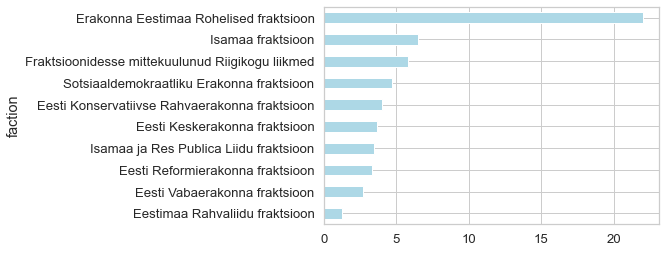

In [86]:
#proportion of environment topic segments from all segments
df_faction_topics_sub.groupby('faction')['proportion'].sum().sort_values().plot(kind='barh', color='lightblue')

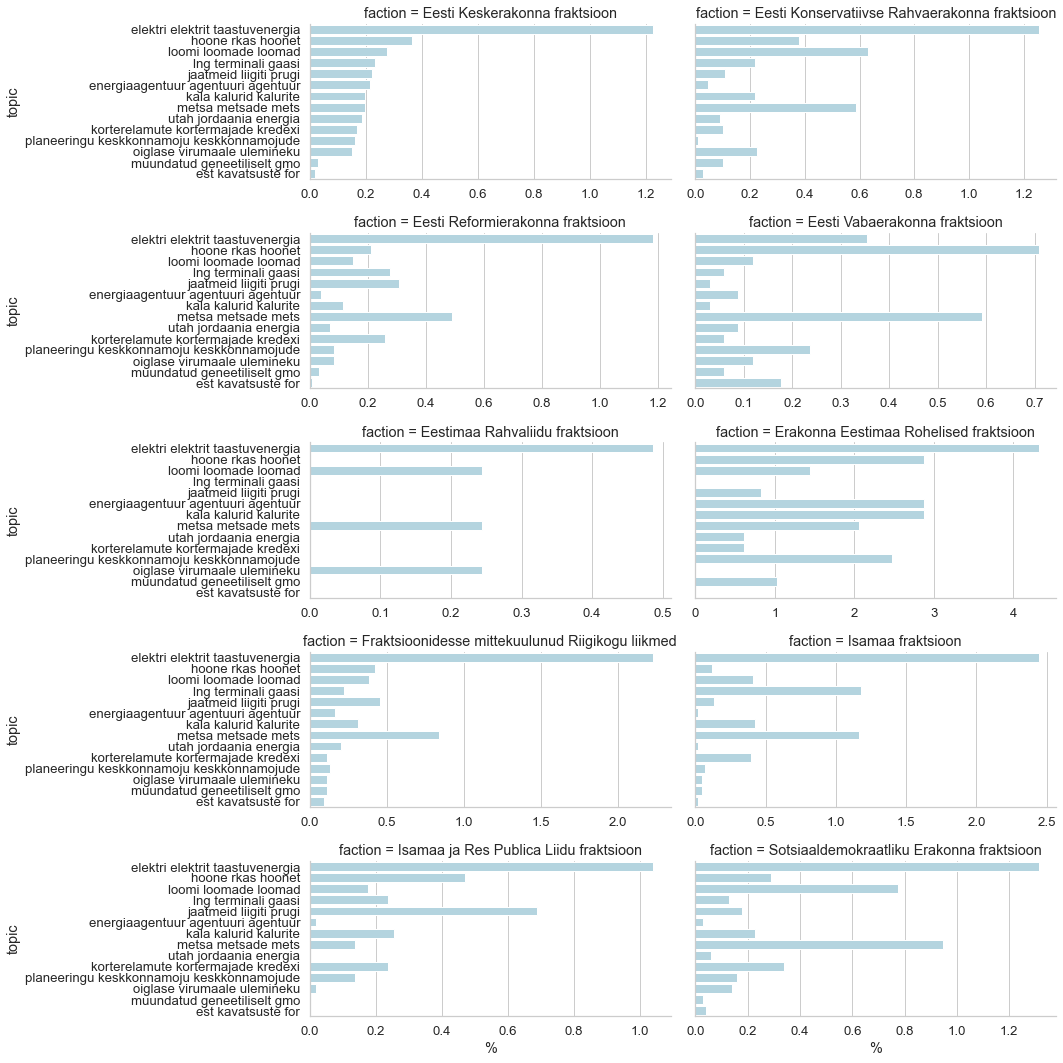

In [80]:
#share of environment topics
plot_catplot(df_faction_topics_sub, 
             'proportion', 'topic', 'faction', '%', 
             'visualisations/png/environment/action_env_topic_proportions.png',
             font_scale=1.2, sns_style='whitegrid', sharex=False,
             sharey=True, color='lightblue', col_wrap=2,
             height=3., aspect=2.5)